In [1]:
import torch as torch
from network.metric.accuracy import acc_srcnn_tiny_radar
from network.models.classifiers.tiny_radar import TinyRadarNN
from network.models.sr_classifier.SRCnnTinyRadar import CombinedSRCNNClassifier
from network.models.super_resolution.drln import Drln
from network.models.super_resolution.srcnn import SRCnn
from network.runner import Runner
from utils.utils_paths import get_time_in_string
from utils.utils_images import Normalization
import os
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifftshift, ifft
from data_loader.tiny_preprocess import pipeline_sr
from data_loader.tiny_data import load_tiny_data


In [2]:
from network.models.super_resolution import srcnn


def model_dirs(base_dir:str):
    res = []
    for model_arch in os.listdir(base_dir):
        if model_arch == ".DS_Store":
            continue
        if model_arch == "row_8_col_64_d_none_u_cubic":
            continue
        arch_dir = os.path.join(base_dir, model_arch)
        dataset_name = "_row_4_col_4_d_none_u_cubic_normalization.range_neg_1_1"
        dataset_dir = os.path.join(arch_dir, dataset_name)
        for train_cg in os.listdir(dataset_dir):
            if train_cg == ".DS_Store":
                continue
            for model in os.listdir(os.path.join(dataset_dir, train_cg)):
                if model == ".DS_Store":
                    continue
                if "max_acc" in model:
                    res.append(os.path.join(dataset_dir, train_cg, model))
    return res

def get_model(model_dir,num_filters, k, activation):
    tiny_radar = TinyRadarNN()
    srcnn = SRCnn(
        num_features_1=num_filters,
        num_features_2=num_filters,
        kernel_size=(k,k),
        activation=activation,
    )
    model = CombinedSRCNNClassifier(srcnn, tiny_radar)
    model.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))
    model.eval()
    return model

def pixel_range(img, desc):
    min_val = img.min()
    max_val = img.max()
    print(desc + f" pixel range: [{min_val} , {max_val}]")

def plot_img(img, desc):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.title(desc)
    plt.show()

def nom_img(imgs):
    for i in range(imgs.shape[0]):
        for j in range(imgs.shape[1]):
            for k in range(imgs.shape[2]):
                img = imgs[i,j,k,:,:]
                img_max = img.max()
                imgs[i,j,k,:,:] = 2*(img/img_max)-1
    return imgs


class ModelResult:
    def __init__(self, model_path:str):
        self.model_path = model_path
        self.get_model_info()
        self.model = get_model(model_path, int(self.num_filters), int(self.kernel_size[1]), self.activation)
        # self.model.eval()
    
    def get_model_info(self):
        params = self.model_path.split("/")
        model_arch = params[-4]
        self.num_filters = model_arch.split("_")[4]
        self.kernel_size = model_arch.split("_")[10]
        self.activation = model_arch.split("_")[12]
        if self.activation == "leaky":
            self.activation = "leaky_relu"
        train_cg = params[-2]
        self.lr = train_cg.split("_")[1]
        self.sr_loss = train_cg.split("_")[7]
        self.sr_wight = train_cg.split("_")[12]
        self.c_wight = train_cg.split("_")[15]
    
    def plot_res(self,low_res_imgs,hight_res_imgs, label):
        print(self)        

        res = self.model(low_res_imgs[:5])
        res_imgs = res[0].detach().numpy()
        low_res_img = low_res_imgs[0,0,0,:,:]
        higit_res_img_true = hight_res_imgs[0,0,0,:,:]
        higit_res_img_pred = res_imgs[0,0,0,:,:]

        print(label)
        pixel_range(low_res_img, "low res")
        pixel_range(higit_res_img_true, "hight res true")
        pixel_range(higit_res_img_pred, "hight res pred")
        mse1 = np.square(higit_res_img_true - higit_res_img_pred).mean()
        print("mse true - pred: ", mse1)
        mse2 = np.square(higit_res_img_true - low_res_img).mean()
        print("mse true - lr: ", mse2)
        plot_img(low_res_img, "low res")
        plot_img(higit_res_img_true, "hight res true")
        plot_img(higit_res_img_pred, "hight res pred")

    
    def __str__(self) -> str:
        model_arc_f = f"num_filters: {self.num_filters}, kernel_size: {self.kernel_size}, activation: {self.activation}"
        train_cg_f = f"lr: {self.lr}, sr_loss: {self.sr_loss}, sr_wight: {self.sr_wight}, c_wight: {self.c_wight}"
        return model_arc_f + "\n" + train_cg_f

In [3]:
base_path = "/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs/models/sr_classifier"
res = model_dirs(base_path)
r = ModelResult(res[4])
print(r)

num_filters: 32, kernel_size: (3, 3), activation: leaky_relu
lr: 0.001, sr_loss: L1, sr_wight: 0, c_wight: 1


SRCNN - TinyRadarNN results - 

In [4]:
from data_loader.tiny_radar_loader import tiny_radar_for_sr_classifier_on_disk, tiny_radar_of_disk


gestures = [
        # "PinchIndex",
        # "PinchPinky",
        # "FingerSlider",
        "FingerRub",
        "SlowSwipeRL",
        "FastSwipeRL",
        # "Push",
        # "Pull",
        # "PalmTilt",
        # "Circle",
        # "PalmHold",
        # "NoHand",
    ]
persons = 4
people = list(range(1, persons, 1))
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
high_res_dir = data_dir + "data_feat/"
low_res_dir = data_dir + "_row_4_col_4_d_none_u_cubic/"
batch_size = 64
training_generator,val_generator,dataset_name, = tiny_radar_for_sr_classifier_on_disk(
            high_res_dir,
            low_res_dir,
            people,
            gestures,
            batch_size,
            Normalization.Range_neg_1_1, # type: ignore
        )
for low_res_imgs, y1 in training_generator:
    break
# y[0].shape, low_res_imgs.shape, y[0].dtype, low_res_imgs.dtype
# print(f'Dtype: {low_res_imgs.dtype}')

# y = y.reshape(64,1,32,492)
# low_res_imgs= low_res_imgs.reshape(64,1,8,123)
# low_res_imgs.shape
# for i in range(10):
#     k=0
#     r = ModelResult(res[i])
#     r.plot_res(low_res_imgs,hight_res_imgs, label[k,k])
dir = data_dir + 'data_npy/'
training_generator,val_generator,dataset_name = tiny_radar_of_disk(dir,4,4,False,people,gestures,False,batch_size,Normalization.Range_0_1)

Getting Doppler map 
down sampling data with 4 cpus
(9450, 8, 123)


IndexError: tuple index out of range

In [5]:
for a,b in training_generator:
    break
a.shape, b.shape, a.dtype, b.dtype

AttributeError: 'list' object has no attribute 'shape'

In [6]:
plt.figure(figsize=(20, 20))
plt.imshow(b[0,:,:])

TypeError: list indices must be integers or slices, not tuple

<Figure size 2000x2000 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))

img = low_res_imgs[0,0,0,:,:]
plt.imshow(img)

In [ ]:
plt.figure(figsize=(20, 20))

img = img.to(torch.float32)
plt.imshow(img)

In [ ]:
def npy_feat_reshape(x: np.ndarray, classifier_shape: bool = True) -> np.ndarray:
    numberOfWindows = x.shape[0]
    numberOfSweeps = x.shape[1]
    numberOfRangePoints = x.shape[2]
    numberOfSensors = x.shape[3]

    numberOfSubWindows = int(numberOfSweeps / 32)

    if classifier_shape:
        x = x.reshape(
            (
                numberOfWindows,
                numberOfSubWindows,
                32,
                numberOfRangePoints,
                numberOfSensors,
            )
        )
    else:
        d0, d1, d2, d3, d4 = x.shape
        x = x.reshape(
            d0 * d1 * d4,
            1,
            d2,
            d3,
        )
        x = x.reshape(-1, d2, d3)
    return x

def doppler_maps_mps(x):
    res = np.zeros(x.shape, dtype=np.float32)
    for i in range(x.shape[1]):
        res[:, i] = abs(fftshift(fft(x[:, i])))
    return res

def normalize_tiny_data_mps(img, pix_norm: Normalization = Normalization.Range_0_1):
    EPSILON = 1e-8

    """normalize the doppler maps of tiny radar dataset"""
    if pix_norm == Normalization.NONE:
        return img
    elif pix_norm == Normalization.Range_0_1:
        return (img - np.min(img)) / (np.max(img) - np.min(img) + EPSILON)
    elif pix_norm == Normalization.Range_neg_1_1:
        return (img - np.min(img)) / (np.max(img) - np.min(img) + EPSILON) * 2 - 1
    else:
        raise ValueError("Unknown normalization type: " + str(type))

In [464]:
from data_loader.tiny_data import load_data
from data_loader.tiny_radar_loader import tiny_radar_for_classifier


numberOfInstanceWindows = 3
lengthOfSubWindow = 32

gestures = [
        # "PinchIndex",
        # "PinchPinky",
        # "FingerSlider",
        # "FingerRub",
        # "SlowSwipeRL",
        # "FastSwipeRL",
        # "Push",
        "Pull",
        # "PalmTilt",
        # "Circle",
        # "PalmHold",
        # "NoHand",
    ]
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/data_feat/"
data_dir1 = "/Users/netanelblumenfeld/Desktop/data/11G/data_npy/"

persons = 4
people = list(range(1, persons, 1))

# data_feat = load_data(data_dir,people,gestures,numberOfInstanceWindows,lengthOfSubWindow,"doppler")
# data_npy = load_data(data_dir1,people,gestures,numberOfInstanceWindows,lengthOfSubWindow,"npy")
x,y,_ =tiny_radar_for_classifier(data_dir,people,gestures,16,Normalization.Range_0_1,0.1)


In [465]:
for a,b in x:
    break
a.shape

torch.Size([16, 5, 32, 492, 2])

In [ ]:
data_dir1 = "/Users/netanelblumenfeld/Desktop/data/11G/data_npy/"

low,high = load_tiny_data(data_dir1,people,gestures,4,4,True,Normalization.Range_0_1,"npy","sr")

In [ ]:
low.shape, high.shape, low.dtype, high.dtype


In [ ]:
low.shape, high.shape, low.dtype, high.dtype

In [ ]:
plt.figure(figsize=(20, 20))

plt.imshow(low[2,0,:,:,1])

In [ ]:
plt.figure(figsize=(20, 20))

plt.imshow(high[2,0,:,:,1])


In [ ]:
import cv2
def down_sample_data(
    data: np.ndarray, row_factor: int, col_factor: int, up_sample: bool = False
) -> np.ndarray:
    def _down_sample(img: np.ndarray, row_factor: int, col_factor: int) -> np.ndarray:
        return img[::row_factor, ::col_factor]

    def _up_scale(img: np.ndarray, dim_up: tuple[int, int]) -> np.ndarray:
        real_img = np.real(img)
        imag_img = np.imag(img)
        data_real_up = cv2.resize(real_img, dim_up, interpolation=cv2.INTER_CUBIC)
        data_imag_up = cv2.resize(imag_img, dim_up, interpolation=cv2.INTER_CUBIC)
        return data_real_up + 1j * data_imag_up

    img = _down_sample(data, row_factor, col_factor)
    if up_sample:
        org_dim = (data.shape[1], data.shape[0])
        img = _up_scale(img, org_dim)
    return img
def doppler_map(x: np.ndarray) -> np.ndarray:
    """Compute the doppler map for velocity of a single instance. The input is a 2D array of shape (freq_ax, range_ax)"""
    assert x.ndim == 2
    freq_ax, range_ax = x.shape
    res = np.zeros((freq_ax, range_ax), dtype=np.float32)
    for i in range(range_ax):
        res[:, i] = abs(fftshift(fft(x[:, i])))
    return res

def plot_doppler(img, prf,scale = 1,k=1):
    M = img.shape[0]
    dop_resolution = int(prf / M)

    print(f'doppler res = {dop_resolution}')
    max_freq = img.shape[0]
    # const = (3e8*256)/(2*60e10*max_freq) * 100
    const = (256)/(max_freq*scale)

    start = -1*prf//2
    end = prf//2
    y_axis = (np.arange(start,end, dop_resolution)).round(2) 
    print(f'freq res = {const}')
    x_axis = (np.arange(0, img.shape[1], 10) * 0.483).round(0) + 100


    plt.figure(figsize=(40, 40))
    plt.yticks(ticks=np.arange(0, img.shape[0], k), labels=y_axis[::-k])
    plt.xticks(ticks=np.arange(0, img.shape[1], 10), labels=x_axis) 
    # plt.gca().invert_yaxis()
    plt.imshow(img)
    plt.xlabel('Range [cm]')
    plt.ylabel('Doppler [1/s]')
    plt.show()


In [ ]:
dataGesture = np.load("/Users/netanelblumenfeld/Desktop/data/11G/data_npy/p6/Pull_1s.npy")
windowLength=32
numberOfWindows = dataGesture.shape[0]
numberOfSweeps = dataGesture.shape[1]
numberOfRangePoints = dataGesture.shape[2]
numberOfSensors = dataGesture.shape[3]
numberOfSubWindows = int(numberOfSweeps / windowLength)
dataGesture = dataGesture.reshape(
                (
                    numberOfWindows,
                    numberOfSubWindows,
                    windowLength,
                    numberOfRangePoints,
                    numberOfSensors,
                )
            )
dataGesture.shape


In [ ]:
d = np.load("/Users/netanelblumenfeld/Desktop/data/11G/data_feat/p6/SlowSwipeRL_1s_wl32_doppl.npy")
img_r = d[-1,1,:,:,1]
print(img_r.shape)
plot_doppler(img_r,prf=256,k=4)


(32, 492)
doppler res = 8
freq res = 8.0


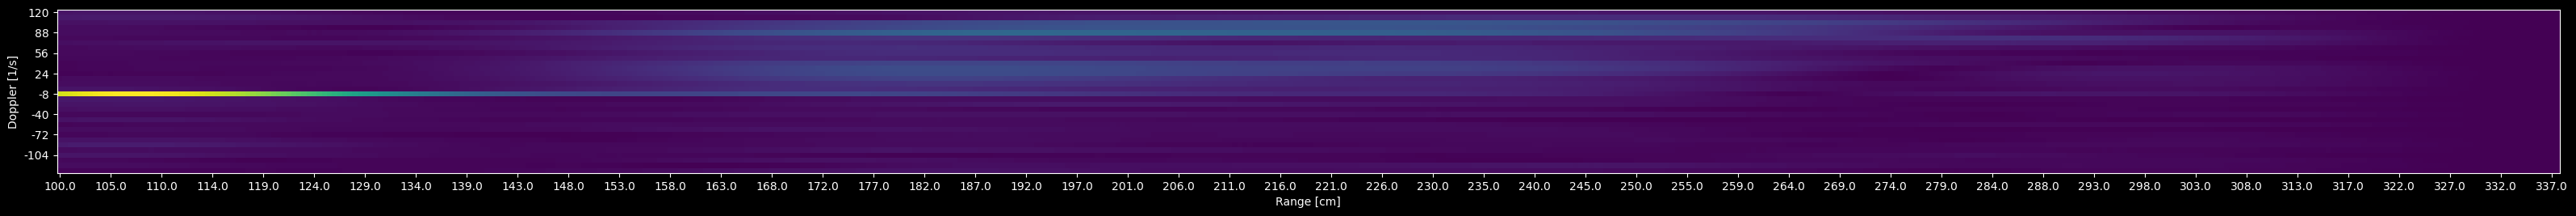

In [449]:
d = np.load("/Users/netanelblumenfeld/Desktop/data/11G/data_npy/p6/SlowSwipeRL_1s.npy")
d = d.reshape(d.shape[0],5,32,492,2)
img = d[-3,2,:,:,1]
signal = img.copy()
print(img.shape)
# do = doppler_map(img)
do = np.abs(fftshift(fft(img,axis=0),axes=0))
plot_doppler(do,prf=256,k=4)

In [ ]:
ds = img[::2,::2]
print(ds.shape)
ds = doppler_map(ds)
plot_doppler(ds,prf=256/2,k=1)



In [456]:
prf = 256
new_prf = 64
const = (3e8)/(2*60e10)
doppler_res = int(prf / 32)
velocity_res = const * doppler_res
print(f'doppler res = {doppler_res}, velocity res = {velocity_res}')

doppler res = 8, velocity res = 0.002


In [457]:
orig_doppler_axis = np.linspace(-1*prf//2,prf//2,32).round(2)
new_doppler_axis = np.linspace(-1*new_prf//2,new_prf//2,16).round(2)
print(orig_doppler_axis)

[-128.   -119.74 -111.48 -103.23  -94.97  -86.71  -78.45  -70.19  -61.94
  -53.68  -45.42  -37.16  -28.9   -20.65  -12.39   -4.13    4.13   12.39
   20.65   28.9    37.16   45.42   53.68   61.94   70.19   78.45   86.71
   94.97  103.23  111.48  119.74  128.  ]


In [458]:
print(new_doppler_axis)

[-32.   -27.73 -23.47 -19.2  -14.93 -10.67  -6.4   -2.13   2.13   6.4
  10.67  14.93  19.2   23.47  27.73  32.  ]


(32, 492)
doppler res = 8
freq res = 8.0


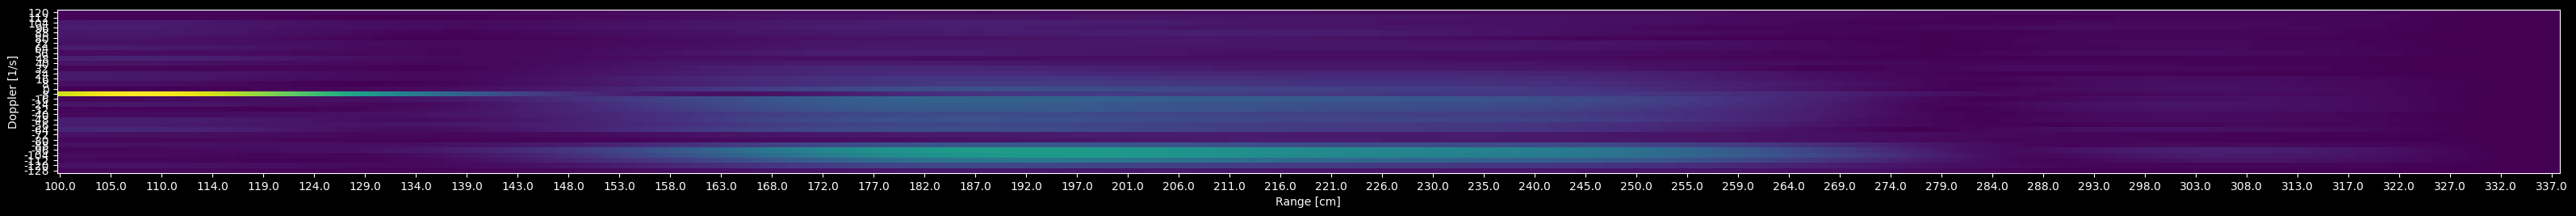

In [478]:
d = np.load("/Users/netanelblumenfeld/Desktop/data/11G/data_npy/p6/SlowSwipeRL_1s.npy")
d = d.reshape(d.shape[0],5,32,492,2)
img = d[-2,2,:,:,1]
signal = img.copy()
print(img.shape)
# do = doppler_map(img)
do = np.abs(fftshift(fft(img,axis=0),axes=0))
plot_doppler(do,prf=256,k=1)


doppler res = 8
freq res = 8.0


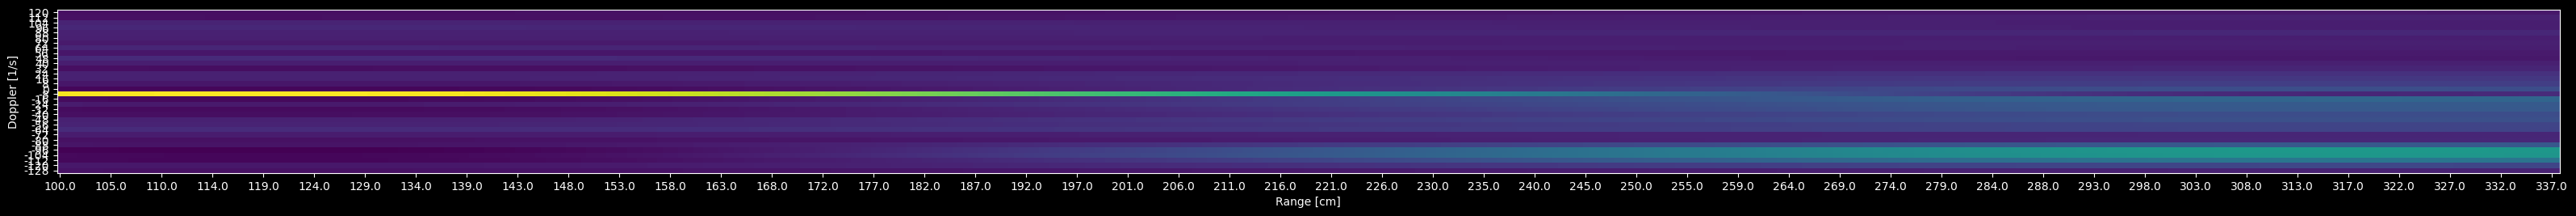

In [483]:
do_dsr = do[::1,::250]
updo = cv2.resize(do_dsr, (492,32), interpolation=cv2.INTER_CUBIC)
plot_doppler(updo,prf=256,k=1)

In [484]:
np.linalg.norm(updo-do)

34.63958

doppler res = 8
freq res = 8.0


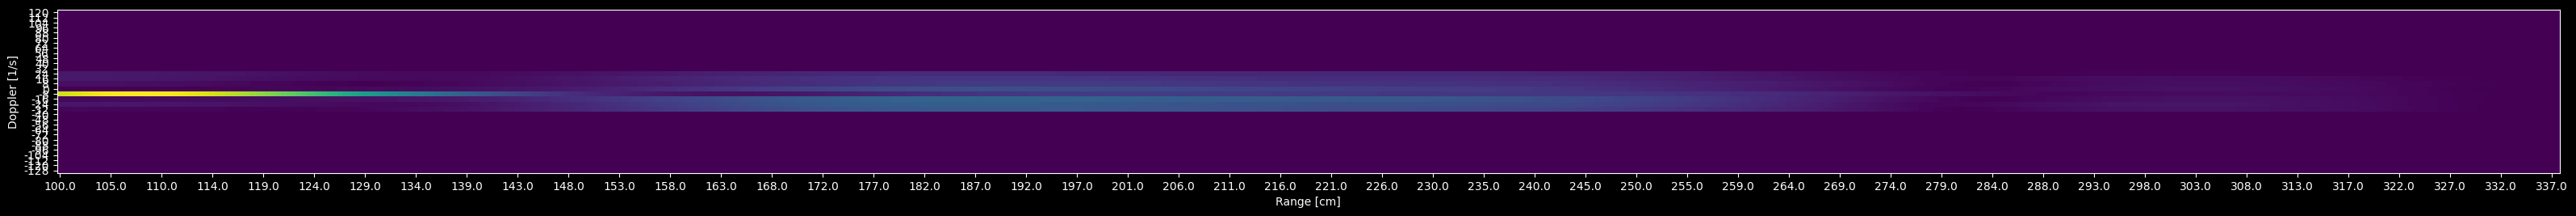

In [485]:
do_lowpass = np.zeros_like(do)
do_lowpass[12:20,:] = do[12:20,:]
plot_doppler(do_lowpass,prf=256,k=1)



doppler res = 2
freq res = 8.0


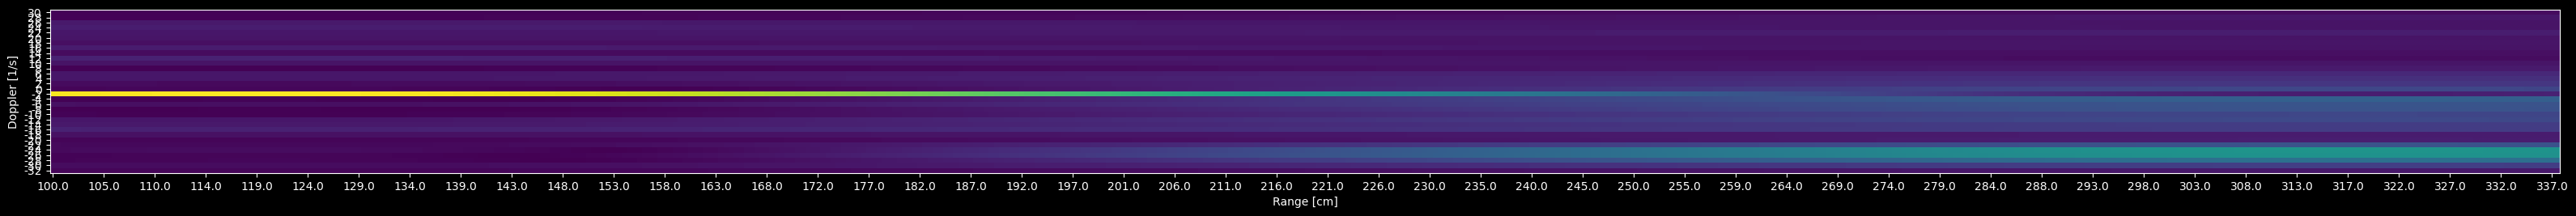

In [489]:
def _up_scale(img: np.ndarray, dim_up: tuple[int, int]) -> np.ndarray:
        real_img = np.real(img)
        imag_img = np.imag(img)
        data_real_up = cv2.resize(real_img, dim_up, interpolation=cv2.INTER_CUBIC)
        data_imag_up = cv2.resize(imag_img, dim_up, interpolation=cv2.INTER_CUBIC)
        return data_real_up + 1j * data_imag_up
do_lowpass_time = ifft(ifftshift(do,axes=0),axis=0)
ds_time = do_lowpass_time[::1,::250]
ds_time_up =_up_scale(ds_time, (492,32))
ds_do = doppler_map(ds_time_up)
plot_doppler(ds_do,prf=64,k=1)


doppler res = 8
freq res = 8.0


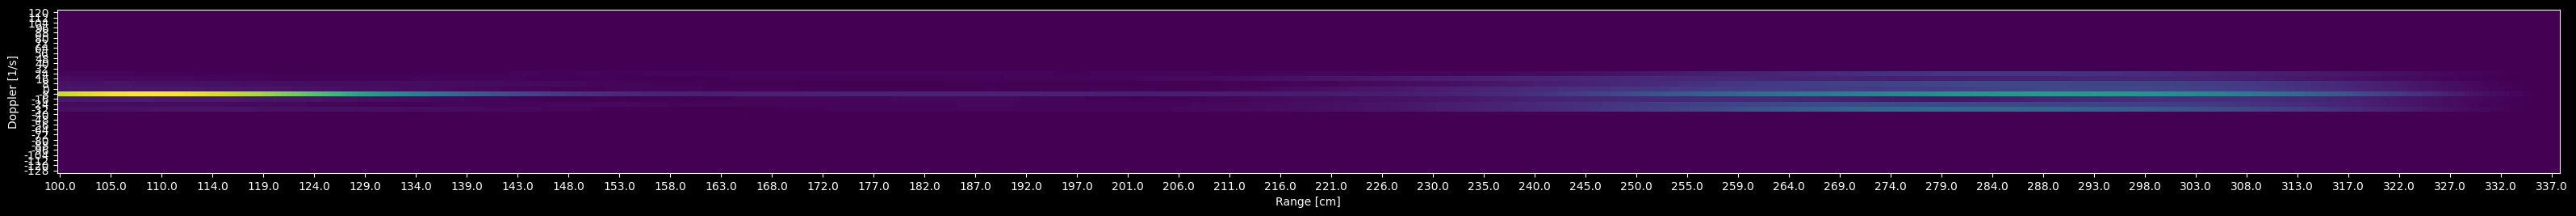

In [470]:
plot_doppler(a[2,3,:,:,0],prf=256,k=1)
